In [1]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(1, parent_dir+'\Covariance and Adjacency Matrix')
from DataManager import dataManager

name: X_test
shape: (640, 31, 1518)
-----------------------
name: X_train
shape: (640, 31, 1395)
-----------------------
name: clip_sizes_test
shape: (2, 129)
-----------------------
name: clip_sizes_train
shape: (2, 127)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 1518)
-----------------------
name: sel_win_nums_train
shape: (1, 1395)
-----------------------
name: soz_ch_ids
shape: (5, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 1518)
-----------------------
name: y_train
shape: (1, 1395)
-----------------------


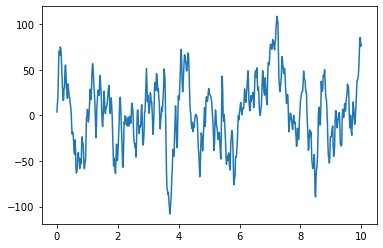

In [2]:
import h5py
import numpy as np
filepath = parent_dir+'\datasets\sample_patients\pat_FR_620.mat'
variables = {}
f = h5py.File(filepath, 'r')
for k, v in f.items():
    variables[k] = np.array(v)
for key in variables.keys():
    print("name:", key)
    print("shape:", variables[key].shape)
    print("-----------------------")
#print sample EGG signal from one node
import matplotlib.pyplot as plt

plt.figure()
ax = plt.axes()
X_train = variables["X_train"]
X_test = variables["X_test"]

ax.plot(np.linspace(0, 10, 640), X_train[:,5,0])

In [3]:
def shuffle_train_test(variables, train_ratio = 0.7, indices = None, print_summary = True):
    data_all = np.concatenate((variables["X_train"], variables["X_test"]), axis = 2)
    labels_all = np.concatenate((variables["y_train"], variables["y_test"]), axis = 1)
    #if indices == None:
    #    indices = np.random.permutation(data_all.shape[2])
    split_ind = int(train_ratio * data_all.shape[2])
    training_idx, test_idx = indices[:split_ind], indices[split_ind:]
    #print(split_ind, training_idx.shape)
    variables["X_train"], variables["X_test"] = data_all[:,:,training_idx], data_all[:,:,test_idx]
    variables["y_train"], variables["y_test"] = labels_all[:,training_idx], labels_all[:,test_idx]
    if print_summary:
        print("X_train:", variables["X_train"].shape)
        print("X_test:", variables["X_test"].shape)
        print("y_train:", variables["y_train"].shape, "Positive labes:", np.sum(variables["y_train"]))
        print("y_test:", variables["y_test"].shape, "Positive labes:",np.sum(variables["y_test"]))
    return variables, indices

In [4]:
indices = np.load("shuffle5050.npy")
variables, indices = shuffle_train_test(variables, indices = indices, train_ratio = 0.5, print_summary = True)

X_train: (640, 31, 1456)
X_test: (640, 31, 1457)
y_train: (1, 1456) Positive labes: 159.0
y_test: (1, 1457) Positive labes: 162.0


In [5]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))
#dm.normalize()
#dm.sanity_check(4.514*10**-1, -10**-3, parent_dir)

--------data manager successfully initialized--------


## create normalized adjacency matrix 


In [6]:
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
def show_heat_map(m):
    plt.imshow(m, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()
    
    
def create_DAD(adj):
    np.fill_diagonal(adj, 1)
    rowsum = np.sum(adj, axis=1)
    d = np.diag_indices(adj.shape[0]) 
    D = np.zeros(adj.shape)
    D[d] = rowsum
    #print(rowsum)
    D = fractional_matrix_power(D, -0.5)
    #print(D)
    return D@adj@D

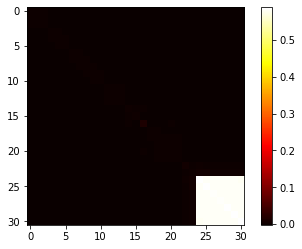

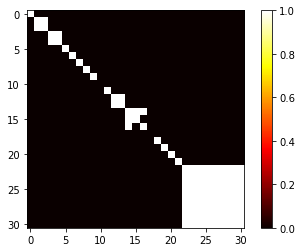

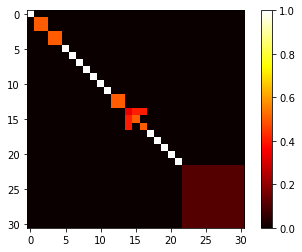

In [7]:
show_heat_map(dm.P_avg_train)
#create DAD from dm
n = 1*10**-3
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))
Araw = dm.A_train

## Modified GDE Class

In [8]:
# solvers.

"""
General Runge-Kutta Solver.
https://en.wikipedia.org/wiki/Runge–Kutta_methods

b_tableau, nested tuple, contains weights of integration. 
f, function, is the function to iterate. Should only be a function of x, t. 
x0, torch.Tensor, is the intial condition.
t0, torch.Tensor, is the start time of integration.
t1, torch.Tensor, is the end time of integration.
N, int, is the desired number of timesteps.

returns x, torch.Tensor, estimated solution of dy/dx = f(x,t) at time t1. 
"""

def explicit_RK(b_tableau, f, x0, t0, t1, N):        
    h = (t1 - t0) / float(N) # calculate step size
    x = x0 # initialize saved dynamics
    mesh = (t0 + h * i for i in range(N)) # generator of time values
    for time in mesh:
        
        k = [f(x, time + h*b_tableau[0][0])] # Covers the first row of the Butcher tableau. 
        for i, row in enumerate(b_tableau[1:-1]): # Covers the middle rows of the Butcher tableau.
            k.append(f(x + sum(w * k[idx] * h for idx, w in enumerate(row[1:])), time + row[0] * h)) # calculate k's. 
        x = x + sum(w * k_i * h for k_i, w in zip(k, b_tableau[-1])) # calculate timestep 
    return x

'''
map everything out:
'y' here is H(t) = H(t-1) + (DAD dot H(t-1) dot W)
'''
RK4 = ((  0,),
       (1/2, 1/2,),
       (1/2,   0,  1/2,),
       (  1,   0,    0,   1,),
       (1/6, 1/3, 1/3, 1/6,))

EF = ((0,),
      (1,))

In [9]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd.functional import vjp
import time

In [10]:
# GCN Block for body layers
class Block(nn.Module):
    def __init__(self, A, features, activation, num_layers):
        super(Block, self).__init__()
        self.features = features
        self.activation = activation
        self.num_layers = num_layers
        self.A = A

    def forward(self, x, t, net_params):
        weights = net_params.view(self.num_layers, self.features, self.features)
        
        x = x.view(-1, self.A.size(1), self.features)
        for i in range(self.num_layers):
            x = self.A.matmul(x).matmul(weights[i,:,:])
            x = self.activation(x)

        return x

    def num_params(self):
        return self.features * self.features * self.num_layers

In [11]:
# Convenience tuple -> tensor function
def flatten(*args):
    return(torch.cat(tuple(torch.flatten(arg) for arg in args), dim=0).view(1,-1))

# Convenience tensor -> tuple function
def unflatten(x, n_e, sizes):
    return (x[0, 0:n_e[0]].view(sizes[0]),
            x[0, n_e[0]:n_e[0] + n_e[1]].view(sizes[1]),
            x[0, (n_e[0] + n_e[1]):(n_e[0] + n_e[1] + n_e[2])].view(sizes[2]),
            x[0, (n_e[0] + n_e[1] + n_e[2]):].view(sizes[3]),
            )

class Integrate(torch.autograd.Function):
    def __deepcopy__(self, memo):
        return Integrate(copy.deepcopy(memo))
    
    @staticmethod
    def forward(ctx, Integrator, f, x0, t0, t1, N, net_params):
        solution = Integrator(EF, lambda x, t: f(x, t, net_params), x0, t0, t1, N)

        # Save for jacobian calculations in backward()
        ctx.save_for_backward(x0,t0,t1,net_params)
        ctx.solution = solution
        ctx.Integrator = Integrator
        ctx.N = N
        ctx.f = f
        
        return solution
    
    @staticmethod
    def backward(ctx, dL_dz1):
        # Get all saved context
        z0, t0, t1, net_params = ctx.saved_tensors
        z1 = ctx.solution
        N = ctx.N
        f = ctx.f
        
        # Convenience sizes
        batch_size = z0.size()[0]
        img_len = int(z0.numel() / batch_size)

        #print(dL_dz1.shape)
        # Compute derivative w.r.t. to end time of integration
        dL_dt1 = dL_dz1.reshape(batch_size,1,-1).bmm(f(z1, t1, net_params).reshape(batch_size,-1,1))  # Derivative of loss w.r.t t1
        
        #print("dL_dt1", dL_dt1)
        
        # Initial Condition
        num_elements = (z1.numel(), dL_dz1.numel(), batch_size * net_params.numel(), dL_dt1.numel())
        sizes = (z1.size(), dL_dz1.size(), (batch_size, net_params.numel()), dL_dt1.size())
        s0 = flatten(z1, dL_dz1, torch.zeros((batch_size, net_params.numel()), dtype=torch.float32, device=z1.device), -dL_dt1) # initial augmented state
    
        # augmented dynamics function
        def aug_dynamics(s, t, theta):
            s = unflatten(s, num_elements, sizes)
            
            with torch.enable_grad(): 
#                 gradients = [vjp(f, 
#                                  (s[0][i].unsqueeze(0), t, theta), 
#                                   v=-s[1][i].unsqueeze(0),
#                                  )[1] for i in range(batch_size)]
                gradients = vjp(f, 
                                 (s[0], t, theta), 
                                  v=-s[1],
                                 )[1]
                
            return flatten(f(s[0],t,theta),
                    torch.cat([gradients[0]], dim=0), 
                    torch.cat([gradients[2].unsqueeze(0) for i in range(batch_size)], dim=0), 
                    torch.cat([gradients[1].reshape(1,1) for i in range(batch_size)], dim=0),
                   )#.unsqueeze(2)
#             return flatten(f(s[0],t,theta),
#                     torch.cat([gradient[0] for gradient in gradients], dim=0), 
#                     torch.cat([gradient[2].unsqueeze(0) for gradient in gradients], dim=0), 
#                     torch.cat([gradient[1].reshape(1,1) for gradient in gradients], dim=0),
#                    )#.unsqueeze(2)

        # Integrate backwards
        with torch.enable_grad():
            s = ctx.Integrator(EF, lambda x, t: aug_dynamics(x, t, net_params), s0, t1, t0, N)
        
        # Extract derivatives
        _, dL_dz0, dL_dtheta, dL_dt0 = unflatten(s, num_elements, sizes)
                
        # must return something for every input to forward, None for non-tensors
        return None, None, dL_dz0, dL_dt0, dL_dt1, None, dL_dtheta 

In [12]:
class SimularityMatrix(nn.Module):
    def __init__(self, in_features):
        super(SimularityMatrix, self).__init__()
        self.in_features = in_features
        
        self.weight = nn.Parameter(torch.Tensor(in_features))
        #self.weight = torch.squeeze(self.weight)
        
        self.reset_parameters()

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) +')'
    
    def reset_parameters(self):
        stdv = 1. / self.weight.size(0) ** 1/2
        self.weight.data.uniform_(-stdv, stdv)
    
    #computes the simularity matrix:
    # H, feature matrix --> N x D
    # A, precomputed adj matrix --> NxN
    # this method is pretty wack, need to find a vectorized way to do it.
    def forward(self, H, H0):
        #get hidden state (concate H0 and H)
        Z = torch.cat((H0, H), 2)
        M = Z.shape[0]
        N = Z.shape[1]
        D = Z.shape[2]
        #centering normalize Z
        Z = self.fcn(Z)
        return self.get_sim_vectorized(Z)
        
    #simularity between node u and node v (shape Mx1xD)
    #return the u,v index of the simularity matrix
    def get_sim(self, u,v):
        theta = torch.diag(self.weight)
        #print(self.weight)
        #print(u.shape, theta.shape, self.weight.shape, torch.transpose(v, 1, 2).shape)
        return torch.squeeze(torch.matmul(torch.matmul(u, theta), torch.transpose(v, 1, 2)))
        
    def get_sim_vectorized(self, Z): # Z is M x N Sx 2D
        theta = torch.diag(self.weight)
        sim_matrix = torch.matmul(torch.matmul(Z, theta), torch.transpose(Z, 1, 2))
        return sim_matrix
        
    #centering-normalizing (CN) operator
    def fcn(self, Z):
        norm_Z = (Z - torch.mean(Z, dim=2, keepdim=True))
        return norm_Z/torch.std(Z, unbiased=True, dim=2, keepdim=True)
        #(((1/(self.in_features-1)) * torch.sum(norm_Z**2, dim = 2, keepdim = True))**(1/2))

In [13]:
class ODENet(nn.Module):
    def __init__(self, solver, body_channels, hidden_layers, A, solver_params):
        super(ODENet, self).__init__()
        
        # Graph Laplacian
        self.A = A
        
        # Controls amount of parameters
        self.body_channels = body_channels
        self.f = Block(A, body_channels, F.relu, hidden_layers)
        
        # Head
        #self.head = GCN(A, in_channels, body_channels)
        
        # Body
        self.int_f = solver
        self.Integrate = Integrate
        self.solver_params = solver_params
        self.N = solver_params["N"]
        self.h = (solver_params["t1"] - solver_params["t0"]) / solver_params["N"]
        self.t0 = torch.tensor(float(solver_params["t0"]), requires_grad=True)
        self.t1 = torch.tensor(float(solver_params["t1"]), requires_grad=True)
        
        self.net_params = torch.nn.parameter.Parameter(torch.Tensor(self.f.num_params()).normal_(mean=0, std=0.1,generator=None), requires_grad=True)

        # Tail
        self.tail = SimularityMatrix(body_channels*2)
    
    def _apply(self, fn):
        super(ODENet, self)._apply(fn)
        self.t0 = fn(self.t0)
        self.t1 = fn(self.t1)
        return self
    
    def forward(self, h_0):
        x = self.Integrate.apply(self.int_f, self.f, h_0, self.t0, self.t1, self.N, self.net_params) # Vanilla RK4
        x = self.tail(x, h_0)
        return x

In [14]:
class sim_loss(torch.nn.Module):

    def __init__(self):
        super(sim_loss,self).__init__()

    def forward(self, sim_matrix, A, epsilon = 1e-8):
        A_tf = (A!=0)
        M = sim_matrix.shape[0]
        abs_N = torch.sum(A_tf, dim = 1, keepdim = True) # Nx1 matrix
        
        logexp_S = torch.log(torch.sum(torch.exp(sim_matrix), dim = 2, keepdim = True))
        
        
        obj_vector = (torch.sum(A_tf*sim_matrix, dim = 2, keepdim = True) - abs_N * logexp_S)
        return -(1/M)*torch.sum(obj_vector)

In [15]:
#save & load checkpoint
import shutil
from torchsummary import summary
from tqdm import tqdm
def save_ckp(state, f_path):
    torch.save(state, f_path)
    print("model saved")
    
def load_ckp(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    return checkpoint

# takes in numpy arrays
def train_GDE(A, X_train, X_test, checkpoint, load = False, print_summary = True):
    #preprocess inputs
    A = torch.from_numpy(A).float()
    X_train = torch.from_numpy(X_train).float()
    X_test = torch.from_numpy(X_test).float()
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    parameters = checkpoint['parameters']
    cumepoch = 0
    A = A.to(device)
    input_features = X_train.to(device)
    valid_features = X_test.to(device)
    
    #(solver, body_channels, hidden_layers, A, solver_params)
    #initialize model
    model = ODENet(parameters['solver'], parameters['body'], parameters['hidden_layers'], A, parameters['solver_params']).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'], weight_decay=parameters['weight_decay'])
    criterion = sim_loss()
    
    #load past checkpoint if any
    if load:
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        cumepoch = checkpoint['cumepoch']
    
    #print some model info
    if print_summary:
        print(model)
        summary(model, [(31,640)])
    
    n_epochs = parameters['num_epochs']
    batch_size = parameters['batch_size']

    model.train()
    for epoch in range(1, n_epochs+1):

        permutation = torch.randperm(input_features.shape[0])

        for i in tqdm(range(0,input_features.shape[0], batch_size)):
            model.train()
            optimizer.zero_grad()

            indices = permutation[i:i+batch_size] if i+batch_size < input_features.shape[0] else permutation[i:] 
            batch_x= input_features[indices, :,:]
            batch_v= valid_features[indices, :,:]

            sim_matrix = model(batch_x).to(device)
            train_loss = criterion(sim_matrix, A)
            train_loss.backward()
            optimizer.step()
            
            model.eval()
            sim_matrix_valid = model(batch_v).to(device)
            valid_loss = criterion(sim_matrix_valid, A)
            
            print("Epoch:", epoch + cumepoch, "  Batch:", int((i/batch_size)+1),"of size",batch_size, "  Train loss:", float(train_loss), "  Valid loss:",float(valid_loss), end="\r")
        print()
    
    checkpoint = {
        'parameters': parameters,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'cumepoch': n_epochs + cumepoch
    }
    
    return model, checkpoint

In [16]:
#create new model
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test
parameters = {
    'body': dm.X_train.shape[2],
    'solver': explicit_RK,
    'solver_params': {
    "t0": 0,
    "t1": 0.25,
    "N": 5
     },
    'hidden_layers': 2,
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
checkpoint = {'parameters': parameters}

In [17]:
torch.cuda.empty_cache()
model, checkpoint = train_GDE(A, X_train, X_test, checkpoint, load = False, print_summary = True)

ODENet(
  (f): Block()
  (tail): SimularityMatrix (1280)
)


  0%|          | 0/12 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
             Block-1              [-1, 31, 640]               0
             Block-2              [-1, 31, 640]               0
             Block-3              [-1, 31, 640]               0
             Block-4              [-1, 31, 640]               0
             Block-5              [-1, 31, 640]               0
  SimularityMatrix-6               [-1, 31, 31]           1,280
Total params: 1,280
Trainable params: 1,280
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.08
Forward/backward pass size (MB): 0.76
Params size (MB): 0.00
Estimated Total Size (MB): 0.84
----------------------------------------------------------------


 17%|█▋        | 2/12 [00:00<00:01,  5.76it/s]

 33%|███▎      | 4/12 [00:00<00:01,  7.02it/s]

 50%|█████     | 6/12 [00:00<00:00,  6.63it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  6.11it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  5.94it/s]

100%|██████████| 12/12 [00:01<00:00,  6.88it/s]

Epoch: 1   Batch: 12 of size 128   Train loss: 307.5357971191406   Valid loss: 313.9716796875


In [18]:
save_ckp(checkpoint, "models/model1.pt")

model saved


### some visualization 

In [18]:
model.eval()
test_pred = model(torch.from_numpy(X_train[:128, :,:]).float().to('cuda')).cpu().detach().numpy()

sample, 0   label, 0.0


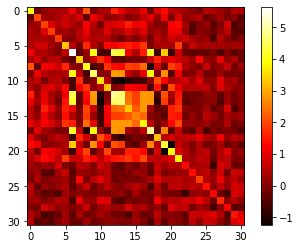

sample, 1   label, 0.0


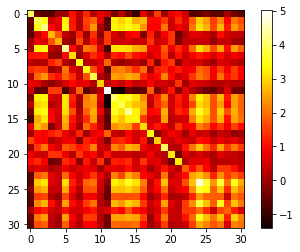

sample, 2   label, 0.0


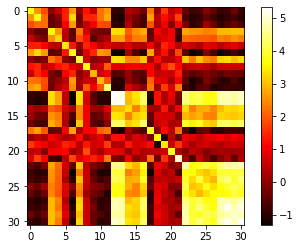

sample, 3   label, 0.0


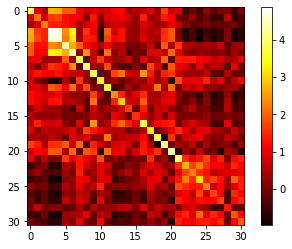

sample, 4   label, 1.0


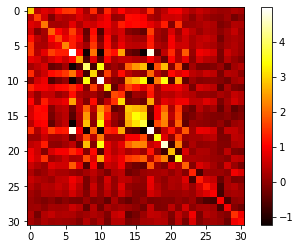

sample, 5   label, 0.0


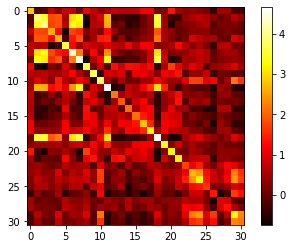

sample, 6   label, 0.0


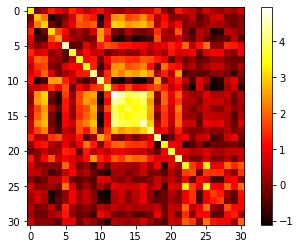

sample, 7   label, 0.0


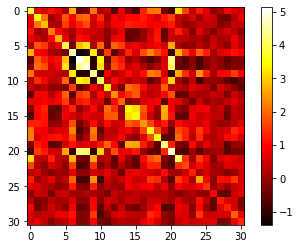

sample, 8   label, 0.0


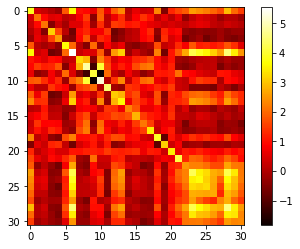

sample, 9   label, 1.0


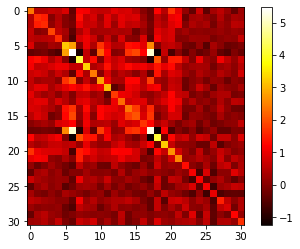

sample, 10   label, 0.0


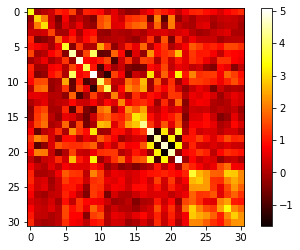

sample, 11   label, 0.0


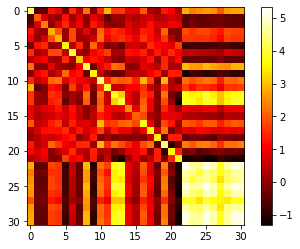

sample, 12   label, 0.0


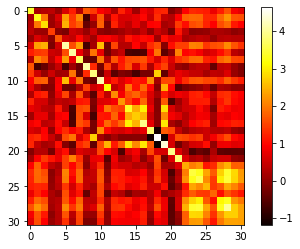

sample, 13   label, 0.0


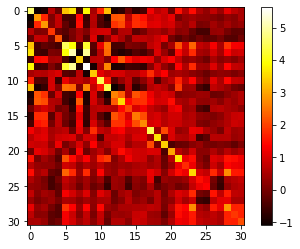

sample, 14   label, 0.0


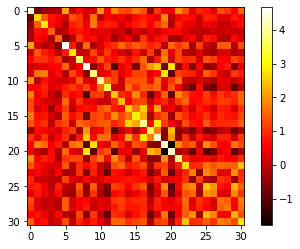

In [19]:
for i in range(15):
    print("sample,", i, "  label,", dm.Y_train[i,0])
    show_heat_map(test_pred[i,:,:])


## quickly try MLP 

In [20]:
sys.path.insert(1, parent_dir+r'\Supervised MLP')
from MLP import *

In [21]:
model.eval()

ODENet(
  (f): Block()
  (tail): SimularityMatrix (1280)
)

In [22]:
sim_train = model(torch.from_numpy(X_train).float().to('cuda')).cpu().detach().numpy()
sim_test = model(torch.from_numpy(X_test).float().to('cuda')).cpu().detach().numpy()

In [23]:
print(sim_train.shape, sim_test.shape)

(1434, 31, 31) (1440, 31, 31)


average ictal


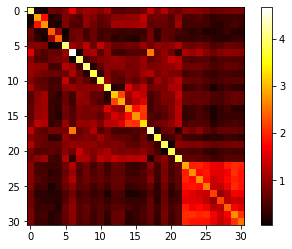

average normal


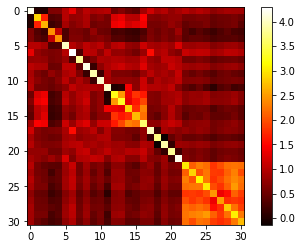

In [24]:
ictal_sum = np.zeros(sim_train[0][:,:].shape)
normal_sum = np.zeros(sim_train[0][:,:].shape)
tc = 0
ni = 0
nn = 0
for i in range(sim_train.shape[0]):
        if dm.Y_train[tc,0] == 1:
            ictal_sum = ictal_sum + sim_train[i,:,:]
            ni+=1
        else:
            normal_sum = normal_sum + sim_train[i,:,:]
            nn+=1
        tc+=1
ictal_sum = ictal_sum / ni
normal_sum = normal_sum / nn
print("average ictal")
show_heat_map(ictal_sum)
print("average normal")
show_heat_map(normal_sum)

In [25]:
MLPparameters = {
    'n_layers':2,
    'layer_size_factor':[1, 1], 
    'dropout':[0.5, 0.3],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
print(MLPparameters)

{'n_layers': 2, 'layer_size_factor': [1, 1], 'dropout': [0.5, 0.3], 'batch_size': 128, 'num_epochs': 900, 'learning_rate': 0.0006, 'weight_decay': 0.005, 'betas': (0.9, 0.999), 'eps': 1e-08}


In [26]:
MLPmodel, _,_ = train_MLP(dm, sim_train, sim_test, MLPparameters, acc_fn=F1, autostop_decay = 0.998, print_summary = True)

MLP(
  (layers): ModuleList(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=496, out_features=496, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=496, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1                  [-1, 496]               0
            Linear-2                  [-1, 496]         246,512
              ReLU-3                  [-1, 496]               0
           Dropout-4                  [-1, 496]               0
            Linear-5                    [-1, 1]             497
           Sigmoid-6                    [-1, 1]               0
Total params: 247,009
Trainable params: 247,009
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.

C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


Epoch: 28   Train loss: 0.2154   Train accuracy: 0.498   Val loss: 0.2457   Val accuracy: 0.511    weighted Val loss: 0.3459
Epoch: 29   Train loss: 0.2033   Train accuracy: 0.5   Val loss: 0.2483   Val accuracy: 0.508    weighted Val loss: 0.3458
Epoch: 30   Train loss: 0.2226   Train accuracy: 0.453   Val loss: 0.2602   Val accuracy: 0.521    weighted Val loss: 0.3456
Epoch: 31   Train loss: 0.1928   Train accuracy: 0.625   Val loss: 0.2713   Val accuracy: 0.515    weighted Val loss: 0.3454
Epoch: 32   Train loss: 0.2075   Train accuracy: 0.473   Val loss: 0.2614   Val accuracy: 0.505    weighted Val loss: 0.3453
Epoch: 33   Train loss: 0.1975   Train accuracy: 0.534   Val loss: 0.241   Val accuracy: 0.514    weighted Val loss: 0.3451
Epoch: 34   Train loss: 0.2238   Train accuracy: 0.51   Val loss: 0.2438   Val accuracy: 0.54    weighted Val loss: 0.3449
0.54 ----------saved-----------
Epoch: 35   Train loss: 0.1957   Train accuracy: 0.488   Val loss: 0.287   Val accuracy: 0.494    

Epoch: 95   Train loss: 0.1208   Train accuracy: 0.727   Val loss: 0.2427   Val accuracy: 0.569    weighted Val loss: 0.3341
Epoch: 96   Train loss: 0.1332   Train accuracy: 0.74   Val loss: 0.2371   Val accuracy: 0.558    weighted Val loss: 0.3339
Epoch: 97   Train loss: 0.1245   Train accuracy: 0.747   Val loss: 0.2551   Val accuracy: 0.54    weighted Val loss: 0.3338
Epoch: 98   Train loss: 0.1359   Train accuracy: 0.718   Val loss: 0.2507   Val accuracy: 0.57    weighted Val loss: 0.3336
Epoch: 99   Train loss: 0.1136   Train accuracy: 0.76   Val loss: 0.2497   Val accuracy: 0.563    weighted Val loss: 0.3334
Epoch: 100   Train loss: 0.1175   Train accuracy: 0.705   Val loss: 0.292   Val accuracy: 0.545    weighted Val loss: 0.3333
Epoch: 101   Train loss: 0.1212   Train accuracy: 0.769   Val loss: 0.2605   Val accuracy: 0.567    weighted Val loss: 0.3332
Epoch: 102   Train loss: 0.1109   Train accuracy: 0.715   Val loss: 0.2429   Val accuracy: 0.535    weighted Val loss: 0.333
Epo

Epoch: 160   Train loss: 0.1014   Train accuracy: 0.79   Val loss: 0.2537   Val accuracy: 0.558    weighted Val loss: 0.3248
Epoch: 161   Train loss: 0.1025   Train accuracy: 0.752   Val loss: 0.2957   Val accuracy: 0.547    weighted Val loss: 0.3248
Epoch: 162   Train loss: 0.0954   Train accuracy: 0.81   Val loss: 0.2883   Val accuracy: 0.541    weighted Val loss: 0.3247
Epoch: 163   Train loss: 0.0993   Train accuracy: 0.784   Val loss: 0.2605   Val accuracy: 0.555    weighted Val loss: 0.3245
Epoch: 164   Train loss: 0.1016   Train accuracy: 0.799   Val loss: 0.2514   Val accuracy: 0.561    weighted Val loss: 0.3244
Epoch: 165   Train loss: 0.1194   Train accuracy: 0.766   Val loss: 0.2748   Val accuracy: 0.545    weighted Val loss: 0.3243
Epoch: 166   Train loss: 0.0896   Train accuracy: 0.838   Val loss: 0.2701   Val accuracy: 0.533    weighted Val loss: 0.3242
Epoch: 167   Train loss: 0.1094   Train accuracy: 0.715   Val loss: 0.3145   Val accuracy: 0.523    weighted Val loss: 0

In [29]:
for i in range(5,100, 5):
    t = i/100;
    eval_mlp(MLPmodel, sim_test, dm, threshold = t)

threshold: 0.05  validation loss: 0.257 F1 accuracy 0.378 Precision accuracy 0.254 Recall accuracy 0.735 AUC accuracy: 0.738
threshold: 0.1  validation loss: 0.257 F1 accuracy 0.472 Precision accuracy 0.37 Recall accuracy 0.652 AUC accuracy: 0.759
threshold: 0.15  validation loss: 0.257 F1 accuracy 0.507 Precision accuracy 0.45 Recall accuracy 0.581 AUC accuracy: 0.748
threshold: 0.2  validation loss: 0.257 F1 accuracy 0.534 Precision accuracy 0.539 Recall accuracy 0.529 AUC accuracy: 0.737
threshold: 0.25  validation loss: 0.257 F1 accuracy 0.573 Precision accuracy 0.626 Recall accuracy 0.529 AUC accuracy: 0.745
threshold: 0.3  validation loss: 0.257 F1 accuracy 0.579 Precision accuracy 0.669 Recall accuracy 0.51 AUC accuracy: 0.74
threshold: 0.35  validation loss: 0.257 F1 accuracy 0.583 Precision accuracy 0.706 Recall accuracy 0.497 AUC accuracy: 0.736
threshold: 0.4  validation loss: 0.257 F1 accuracy 0.546 Precision accuracy 0.723 Recall accuracy 0.439 AUC accuracy: 0.709
threshol

### Archived code

In [ ]:
#ODE Part and Adjoint Method

# Convenience tuple -> tensor function
def flatten(*args):
    return(torch.cat(tuple(torch.flatten(arg) for arg in args), dim=0).view(1,-1))

# Convenience tensor -> tuple function
def unflatten(x, n_e, sizes):
    return (x[0, 0:n_e[0]].view(sizes[0]),
            x[0, n_e[0]:n_e[0] + n_e[1]].view(sizes[1]),
            x[0, (n_e[0] + n_e[1]):(n_e[0] + n_e[1] + n_e[2])].view(sizes[2]),
            x[0, (n_e[0] + n_e[1] + n_e[2]):].view(sizes[3]),
            )

class Integrate(torch.autograd.Function):
    def __deepcopy__(self, memo):
        return Integrate(copy.deepcopy(memo))
    
    @staticmethod
    def forward(ctx, Integrator, f, x0, t0, t1, N, net_params, A):
                
        solution = Integrator(EF, lambda x, t: f(x, t, net_params, A), x0, t0, t1, N)
            
        # Save for jacobian calculations in backward()
        ctx.save_for_backward(x0,t0,t1,net_params,A)
        ctx.solution = solution
        ctx.Integrator = Integrator
        ctx.N = N
        ctx.f = f
        
        return solution
    
    @staticmethod
    def backward(ctx, dL_dz1):
        # Get all saved context
        z0, t0, t1, net_params,A = ctx.saved_tensors
        z1 = ctx.solution
        N = ctx.N
        f = ctx.f
        
        print("dL_dz1", dL_dz1.size())
        print("net_params", net_params.size())
        
        
        s0 = [z1, dL_dz1 ,torch.zeros(net_params.size(), dtype=torch.float32)]
        print("s0", s0.size())
        
        def aug_dynamics(s, t, theta, A):
            zt = s[0]
            at = s[1]
            
            
            with torch.enable_grad(): 
                gradients = [vjp(f, 
                                 (s[0][i].unsqueeze(0), t, theta), 
                                  v=-s[1][i].unsqueeze(0),
                                 )[1] for i in range(batch_size)]
                
            return flatten(f(s[0],t,theta),
                    torch.cat([gradient[0] for gradient in gradients], dim=0), 
                    torch.cat([gradient[2].unsqueeze(0) for gradient in gradients], dim=0), 
                    torch.cat([gradient[1].reshape(1,1) for gradient in gradients], dim=0),
                   )#.unsqueeze(2)
        
        '''
        # Convenience sizes
        batch_size = z0.size()[0]
        img_len = int(z0.numel() / batch_size)

        # Compute derivative w.r.t. to end time of integration
        dL_dt1 = dL_dz1.view(batch_size,1,-1).bmm(f(z1, t1, net_params).view(batch_size,-1,1))  # Derivative of loss w.r.t t1
        
        #print("dL_dt1", dL_dt1)
        
        # Initial Condition
        num_elements = (z1.numel(), dL_dz1.numel(), batch_size * net_params.numel(), dL_dt1.numel())
        sizes = (z1.size(), dL_dz1.size(), (batch_size, net_params.numel()), dL_dt1.size())
        s0 = flatten(z1, dL_dz1, torch.zeros((batch_size, net_params.numel()), dtype=torch.float32), -dL_dt1) # initial augmented state
        
        # augmented dynamics function
        def aug_dynamics(s, t, theta):
            s = unflatten(s, num_elements, sizes)
            
            with torch.enable_grad(): 
                gradients = [vjp(f, 
                                 (s[0][i].unsqueeze(0), t, theta), 
                                  v=-s[1][i].unsqueeze(0),
                                 )[1] for i in range(batch_size)]
                
            return flatten(f(s[0],t,theta),
                    torch.cat([gradient[0] for gradient in gradients], dim=0), 
                    torch.cat([gradient[2].unsqueeze(0) for gradient in gradients], dim=0), 
                    torch.cat([gradient[1].reshape(1,1) for gradient in gradients], dim=0),
                   )#.unsqueeze(2)

        # Integrate backwards
        with torch.enable_grad():
            s = ctx.Integrator(EF, lambda x, t: aug_dynamics(x, t, net_params), s0, t1, t0, N)
        
        # Extract derivatives
        _, dL_dz0, dL_dtheta, dL_dt0 = unflatten(s, num_elements, sizes)
        
        # must return something for every input to forward, None for non-tensors
        return None, None, dL_dz0, dL_dt0, dL_dt1, None, dL_dtheta 
        '''
        return None, None, None, None, None, None, net_params, None

In [ ]:
class GDE(nn.Module):
    def __init__(self, in_features, out_features):
        super(GDE, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
    
    # H, feature matrix
    # A, precomputed adj matrix
    def forward(self, H, t, weight, A): #x, t, net_params, A
        n = torch.matmul(A, torch.matmul(H, weight))
        return F.relu(n)

class SimularityMatrix(nn.Module):
    def __init__(self, in_features):
        super(SimularityMatrix, self).__init__()
        self.in_features = in_features
        self.weight = nn.Parameter(torch.Tensor(in_features))
        self.reset_parameters()

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) +')'
    
    def reset_parameters(self):
        stdv = 1. / self.weight.size(0) ** 1/2
        self.weight.data.uniform_(-stdv, stdv)
    
    #computes the simularity matrix:
    # H, feature matrix --> N x D
    # A, precomputed adj matrix --> NxN
    # this method is pretty wack, need to find a vectorized way to do it.
    def forward(self, H, H0):
        #get hidden state (concate H0 and H)
        Z = torch.cat((H0, H), 2)
        M = Z.shape[0]
        N = Z.shape[1]
        D = Z.shape[2]
        #centering normalize Z
        Z = self.fcn(Z)
        return self.get_sim_vectorized(Z)
        
    #simularity between node u and node v (shape Mx1xD)
    #return the u,v index of the simularity matrix
    def get_sim(self, u,v):
        theta = torch.diag(self.weight)
        #print(self.weight)
        #print(u.shape, theta.shape, self.weight.shape, torch.transpose(v, 1, 2).shape)
        return torch.squeeze(torch.matmul(torch.matmul(u, theta), torch.transpose(v, 1, 2)))
        
    def get_sim_vectorized(self, Z): # Z is M x N Sx 2D
        theta = torch.diag(self.weight)
        sim_matrix = torch.matmul(torch.matmul(Z, theta), torch.transpose(Z, 1, 2))
        return sim_matrix
        
    #centering-normalizing (CN) operator
    def fcn(self, Z):
        norm_Z = (Z - torch.mean(Z, dim=2, keepdim=True))
        return norm_Z/torch.std(Z, unbiased=True, dim=2, keepdim=True)

In [ ]:
# n-layer GCN Network
'''
solver_params = {
    "t0": 0,
    "t1": 1,
    "N": 5,
}
'''
class Net(nn.Module):
    def __init__(self, body_features, solver, solver_params):
        super(Net, self).__init__()
        
        self.f = GDE(body_features,body_features)
        #body
        self.int_f = solver
        self.Integrate = Integrate
        self.solver_params = solver_params
        self.N = solver_params["N"]
        self.h = (solver_params["t1"] - solver_params["t0"]) / solver_params["N"]
        self.t0 = torch.tensor(float(solver_params["t0"]), requires_grad=True)
        self.t1 = torch.tensor(float(solver_params["t1"]), requires_grad=True)
        
        self.net_params = torch.nn.parameter.Parameter(torch.Tensor(body_features, body_features).normal_(mean=0, std=0.1,generator=None), requires_grad=True)
            
        #tail
        self.tail = SimularityMatrix(body_features*2) # size(H_0 + h_u)

    def forward(self, h_0, A):
        #body
        x = self.Integrate.apply(self.int_f, self.f, h_0, self.t0, self.t1, self.N, self.net_params, A)
        
        #tail
        sim_matrix = self.tail(x, h_0)
        return sim_matrix